# Pretraining word2vec
:label:`sec_word2vec_pretraining`


We go on to implement the skip-gram
model defined in
:numref:`sec_word2vec`.
Then
we will pretrain word2vec using negative sampling
on the PTB dataset.
First of all,
let's obtain the data iterator
and the vocabulary for this dataset
by calling the `d2l.load_data_ptb`
function, which was described in :numref:`sec_word2vec_data`


In [1]:
import math
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

## The Skip-Gram Model

We implement the skip-gram model
by using embedding layers and batch matrix multiplications.
First, let's review
how embedding layers work.


### Embedding Layer

As described in :numref:`sec_seq2seq`,
an embedding layer
maps a token's index to its feature vector.
The weight of this layer
is a matrix whose number of rows equals to
the dictionary size (`input_dim`) and
number of columns equals to
the vector dimension for each token (`output_dim`).
After a word embedding model is trained,
this weight is what we need.


In [2]:
embed = nn.Embedding(input_dim=20, output_dim=4)
embed.initialize()
embed.weight

[22:26:39] ../src/storage/storage.cc:196: Using Pooled (Naive) StorageManager for CPU


Parameter embedding0_weight (shape=(20, 4), dtype=float32)

The input of an embedding layer is the
index of a token (word).
For any token index $i$,
its vector representation
can be obtained from
the $i^\textrm{th}$ row of the weight matrix
in the embedding layer.
Since the vector dimension (`output_dim`)
was set to 4,
the embedding layer
returns vectors with shape (2, 3, 4)
for a minibatch of token indices with shape
(2, 3).


In [3]:
x = np.array([[1, 2, 3], [4, 5, 6]])
embed(x)

array([[[ 0.01438687,  0.05011239,  0.00628365,  0.04861524],
        [-0.01068833,  0.01729892,  0.02042518, -0.01618656],
        [-0.00873779, -0.02834515,  0.05484822, -0.06206018]],

       [[ 0.06491279, -0.03182812, -0.01631819, -0.00312688],
        [ 0.0408415 ,  0.04370362,  0.00404529, -0.0028032 ],
        [ 0.00952624, -0.01501013,  0.05958354,  0.04705103]]])

### Defining the Forward Propagation

In the forward propagation,
the input of the skip-gram model
includes
the center word indices `center`
of shape (batch size, 1)
and
the concatenated context and noise word indices `contexts_and_negatives`
of shape (batch size, `max_len`),
where `max_len`
is defined
in :numref:`subsec_word2vec-minibatch-loading`.
These two variables are first transformed from the
token indices into vectors via the embedding layer,
then their batch matrix multiplication
(described in :numref:`subsec_batch_dot`)
returns
an output of shape (batch size, 1, `max_len`).
Each element in the output is the dot product of
a center word vector and a context or noise word vector.


In [4]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = npx.batch_dot(v, u.swapaxes(1, 2))
    return pred

Let's print the output shape of this `skip_gram` function for some example inputs.


In [5]:
skip_gram(np.ones((2, 1)), np.ones((2, 4)), embed, embed).shape

(2, 1, 4)

## Training

Before training the skip-gram model with negative sampling,
let's first define its loss function.


### Binary Cross-Entropy Loss

According to the definition of the loss function
for negative sampling in :numref:`subsec_negative-sampling`, 
we will use 
the binary cross-entropy loss.


In [6]:
loss = gluon.loss.SigmoidBCELoss()

Recall our descriptions
of the mask variable
and the label variable in
:numref:`subsec_word2vec-minibatch-loading`.
The following
calculates the 
binary cross-entropy loss
for the given variables.


In [7]:
pred = np.array([[1.1, -2.2, 3.3, -4.4]] * 2)
label = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = np.array([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

array([0.9352101, 1.8462093])

Below shows
how the above results are calculated
(in a less efficient way)
using the
sigmoid activation function
in the binary cross-entropy loss.
We can consider 
the two outputs as
two normalized losses
that are averaged over non-masked predictions.


In [8]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


### Initializing Model Parameters

We define two embedding layers
for all the words in the vocabulary
when they are used as center words
and context words, respectively.
The word vector dimension
`embed_size` is set to 100.


In [9]:
embed_size = 100
net = nn.Sequential()
net.add(nn.Embedding(input_dim=len(vocab), output_dim=embed_size),
        nn.Embedding(input_dim=len(vocab), output_dim=embed_size))

### Defining the Training Loop

The training loop is defined below. Because of the existence of padding, the calculation of the loss function is slightly different compared to the previous training functions.


In [10]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    net.initialize(ctx=device, force_reinit=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            center, context_negative, mask, label = [
                data.as_in_ctx(device) for data in batch]
            with autograd.record():
                pred = skip_gram(center, context_negative, net[0], net[1])
                l = (loss(pred.reshape(label.shape), label, mask) *
                     mask.shape[1] / mask.sum(axis=1))
            l.backward()
            trainer.step(batch_size)
            metric.add(l.sum(), l.size)
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

Now we can train a skip-gram model using negative sampling.


loss 0.408, 108453.4 tokens/sec on gpu(0)


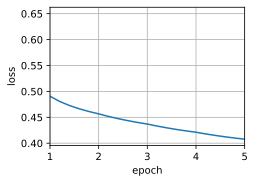

In [11]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

## Applying Word Embeddings
:label:`subsec_apply-word-embed`


After training the word2vec model,
we can use the cosine similarity
of word vectors from the trained model
to 
find words from the dictionary
that are most semantically similar
to an input word.


In [12]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data()
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = np.dot(W, x) / np.sqrt(np.sum(W * W, axis=1) * np.sum(x * x) + 1e-9)
    topk = npx.topk(cos, k=k+1, ret_typ='indices').asnumpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.681: intel
cosine sim=0.662: microprocessor
cosine sim=0.619: memory


## Summary

* We can train a skip-gram model with negative sampling using embedding layers and the binary cross-entropy loss.
* Applications of word embeddings include finding semantically similar words for a given word based on the cosine similarity of word vectors.


## Exercises

1. Using the trained model, find semantically similar words for other input words. Can you improve the results by tuning hyperparameters?
1. When a training corpus is huge, we often sample context words and noise words for the center words in the current minibatch *when updating model parameters*. In other words, the same center word may have different context words or noise words in different training epochs. What are the benefits of this method? Try to implement this training method.


[Discussions](https://discuss.d2l.ai/t/384)
